In [774]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
import itertools
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dynamic Optimization Problem: Dentists

We start of by defining a set of parameters and then build our cost function that our agent is facing when deciding on going to the dentist or not. We plot our cost function. 
The basic idea is that it costs to go to the dentist every time you go, but if you postpone your check ups the total cost will increase.

In [775]:
par = SimpleNamespace()
par.x_t = 0 #x being the current level of usage of your teeth
par.FC = 1 #Fixed cost of going to the dentist
par.MC = 2 #Marginal cost of going to the dentist, depends on your usage of the teeth (when you last went)
par.beta = 0.9 #Discount factor
par.exponent = 1.5 #How bad your teeth decay if you don't see a dentist (I changed this because it was to high)
par.gamma = 0.1
par.T = 3
par.boost = 5

In [776]:
def cost_dentist(par, d, x_t):
    if d == 0: 
        return  0 
    if d == 1: 
        return par.FC + par.MC*x_t #Person goes to the dentist

In [777]:
def teeth_decay(par, d, x_t): #How your teeth are transitioning from one time period to the next
    if d == 0:
        
        x_1 = int(x_t**par.exponent) + 3
    else:
        x_1 = max(x_t - par.boost, 0)
    return x_1

In [778]:
def disutil_ache(par, x_t): 
    disutil = (x_t**(1-par.gamma) - 1) / (1 - par.gamma)
    return int(disutil)

In [779]:
def total_util(par, d, x_t):
    return -cost_dentist(par, d, x_t) - disutil_ache(par, x_t)

In [780]:
par.gamma = 0.6
for i in range(0,10):
    print(disutil_ache(par, i))

-2
0
0
1
1
2
2
2
3
3


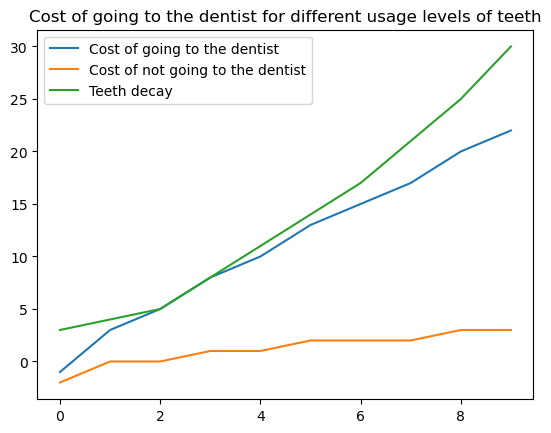

In [781]:
c_going = []
c_not_going = []
expo = []
logo = []
decay = []
for i in range(0,10):
    c_going.append(cost_dentist(par,1, i)+ disutil_ache(par, i))
    c_not_going.append(cost_dentist(par,0, i)+ disutil_ache(par, i))
    decay.append(teeth_decay(par, 0, i))

plt.plot(c_going, label='Cost of going to the dentist')
plt.plot(c_not_going, label='Cost of not going to the dentist')
plt.plot(decay, label='Teeth decay')
plt.title('Cost of going to the dentist for different usage levels of teeth')
plt.legend()
plt.show()


In [782]:
#Say we start with x=0 and live for three time periods and you don't go to the dentist in the last time period. Only t0 and t1 are left to decide

def n_combinations(t):
    digits = (0, 1)
    return list(itertools.product(digits, repeat=t-1))
time = 4
possible_paths = n_combinations(time) #Create all decision combinations, excluding the last time period (d==0)
n_paths = len(possible_paths) #Game starts in t1 with a t0 value. 
x = np.zeros((n_paths, time)) #decay_path_matrix
v = np.zeros((n_paths,time+1))#value_matrix
d_index = np.zeros((n_paths)) #Initiate
decision_indexes = [] #Keeping track of indexes and storing values
for index, val in enumerate(possible_paths):
    
    print('Decision path: ', index,val)
    for t, d in enumerate(val): 
        x_next = teeth_decay(par, d=d, x_t=x[index,t])
        x[index, (t+1)] = x_next
        v[index, (t+1)] = (par.beta**t)*total_util(par, d=d, x_t=x[index, t])
        print('Dental usage in period', t, ' = ', x[index, t])
    v[index, -1] = (par.beta**(time+1))*total_util(par, d=0, x_t=x[index, -1])
    best_path = v.sum(axis=1).argmax() #The decision path maximizing total utility 
    #best_decision_path = decision_indexes[best_path, :] #FIGURE OUT 
print( 'Best decisions')
decision_indexes




Decision path:  0 (0, 0, 0)
Dental usage in period 0  =  0.0
Dental usage in period 1  =  3.0
Dental usage in period 2  =  8.0
Decision path:  1 (0, 0, 1)
Dental usage in period 0  =  0.0
Dental usage in period 1  =  3.0
Dental usage in period 2  =  8.0
Decision path:  2 (0, 1, 0)
Dental usage in period 0  =  0.0
Dental usage in period 1  =  3.0
Dental usage in period 2  =  0.0
Decision path:  3 (0, 1, 1)
Dental usage in period 0  =  0.0
Dental usage in period 1  =  3.0
Dental usage in period 2  =  0.0
Decision path:  4 (1, 0, 0)
Dental usage in period 0  =  0.0
Dental usage in period 1  =  0.0
Dental usage in period 2  =  3.0
Decision path:  5 (1, 0, 1)
Dental usage in period 0  =  0.0
Dental usage in period 1  =  0.0
Dental usage in period 2  =  3.0
Decision path:  6 (1, 1, 0)
Dental usage in period 0  =  0.0
Dental usage in period 1  =  0.0
Dental usage in period 2  =  0.0
Decision path:  7 (1, 1, 1)
Dental usage in period 0  =  0.0
Dental usage in period 1  =  0.0
Dental usage in p

[]

An extension of the model in which age impacts the decay of the theeth is implemented. After age 50 the consequences not going to the dentist dobled the marginal cost.

In [783]:
def teeth_decay_50(par, d, x_t, age):
    if d == 0:
        if age > 50:
            age_diff = age - 50
            age_factor = 1 + 0.5 * age_diff  # gradual increase of 0.5 per year after age 50
            x_1 = int((x_t**par.exponent) * age_factor) + 3
        else:
            x_1 = int(x_t**par.exponent) + 3
    else:
        x_1 = max(x_t - par.boost, 0)
    return x_1

In [784]:
def teeth_decay_50(par, d, x_t):
    if d == 0:
        if x_t > 50:
            age_diff = x_t - 50
            age_factor = 1 + 0.5 * age_diff  # gradual increase of 0.5 per year after age 50
            x_1 = int((x_t**par.exponent) * age_factor) + 3
        else:
            x_1 = int(x_t**par.exponent) + 3
    else:
        x_1 = max(x_t - par.boost, 0)
    return x_1

In [785]:
def cost_dentist(par, d, x_t):
    if d == 0: 
        return  0 
    if d == 1: 
        return par.FC + par.MC*x_t #Person goes to the dentist

In [786]:
def total_util(par, d, x_t):
    if x_t > 50 and d == 0:
        return -cost_dentist(par, d, x_t) - disutil_ache(par, x_t) - par.MC*2*x_t
    else:
        return -cost_dentist(par, d, x_t) - disutil_ache(par, x_t)

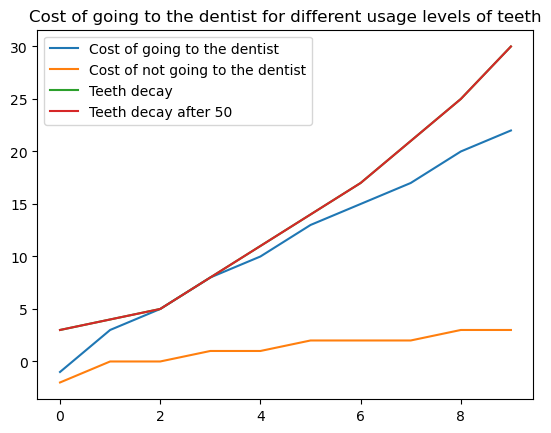

In [787]:
c_going = []
c_not_going = []
expo = []
logo = []
decay = []
decay_50 = []
for i in range(0,10):
    c_going.append(cost_dentist(par,1, i)+ disutil_ache(par, i))
    c_not_going.append(cost_dentist(par,0, i)+ disutil_ache(par, i))
    decay.append(teeth_decay(par, 0, i))
    decay_50.append(teeth_decay_50(par, 0, i))

plt.plot(c_going, label='Cost of going to the dentist')
plt.plot(c_not_going, label='Cost of not going to the dentist')
plt.plot(decay, label='Teeth decay')
plt.plot(decay_50, label='Teeth decay after 50')
plt.title('Cost of going to the dentist for different usage levels of teeth')
plt.legend()
plt.show()

In [788]:
a = np.zeros((8))
a[0]

0.0

In [789]:
.sum(axis=1).argmin()

SyntaxError: invalid syntax (508353973.py, line 1)

### Possible extensions: 

° Income and savings 

° Life style choices (healthy or unhealthy) with different impacts on x.

° Varying MC and FC

° Age impacting decay of teeth. Say after 50 years, consequences of not going (increase in x if d=0) goes up. Or marginal cost could double.

° Implementing a subsidy of one dollar. Does it make more sense to subsidize the marginal or the fixed cost. 

In [ ]:
import numpy as np
from types import SimpleNamespace

# Define problem parameters
par = SimpleNamespace()
par.x_t = 0  # x being the current level of usage of your teeth
par.FC = 1  # Fixed cost of going to the dentist
par.MC = 2  # Marginal cost of going to the dentist, depends on your usage of the teeth (when you last went)
par.beta = 0.99  # Discount factor
par.exponent = 1.2  # How bad your teeth decay if you don't see a dentist
par.T = 5  # Time horizon
par.x_max = 10  # Maximum teeth quality level
par.gamma = 0.1




# Initialize value function
V = np.zeros((par.x_max+1,par.T))

# Iterate over time periods
for t in range(par.T-1, -1, -1):
    # Iterate over teeth quality levels
    for x in range(par.x_max+1):
        # Initialize variables
        min_cost = np.inf
        best_d = None

        if t == par.T: 
            total_cost = disutil_ache(par, x) ##Don't go to the dentist in the last time period, but endure pain
            best_d = 0
        
        else: 
            # Iterate over possible decisions
            for d in [0, 1]:
                # Calculate cost of current decision
                cost = cost_dentist(par, d, x)
                decay = teeth_decay(par, d, x)
                ache = disutil_ache(par, x)
                future_cost = par.beta*V[x,t-1]
                total_cost = cost + future_cost + ache
                
        # Update minimum cost and best decision
        if total_cost < min_cost:
            min_cost = total_cost
            best_d = d
            
        # Update value function
        V[x,t] = min_cost
        
        # Save best decision
        if best_d == 0:
            decision = 'Do not go to the dentist'
        else:
            decision = 'Go to the dentist'
        
        # Print results
        print(f"Time period: {t}, Teeth quality level: {x}, Best decision: {decision}, Expected cost: {min_cost}")


Time period: 4, Teeth quality level: 0, Best decision: Go to the dentist, Expected cost: 0.0
Time period: 4, Teeth quality level: 1, Best decision: Go to the dentist, Expected cost: 3.0
Time period: 4, Teeth quality level: 2, Best decision: Go to the dentist, Expected cost: 5.0
Time period: 4, Teeth quality level: 3, Best decision: Go to the dentist, Expected cost: 8.0
Time period: 4, Teeth quality level: 4, Best decision: Go to the dentist, Expected cost: 11.0
Time period: 4, Teeth quality level: 5, Best decision: Go to the dentist, Expected cost: 14.0
Time period: 4, Teeth quality level: 6, Best decision: Go to the dentist, Expected cost: 17.0
Time period: 4, Teeth quality level: 7, Best decision: Go to the dentist, Expected cost: 20.0
Time period: 4, Teeth quality level: 8, Best decision: Go to the dentist, Expected cost: 23.0
Time period: 4, Teeth quality level: 9, Best decision: Go to the dentist, Expected cost: 25.0
Time period: 4, Teeth quality level: 10, Best decision: Go to th